In [1]:
import pandas as pd
import numpy as np
import dill
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

from exhibit import exhibit as xbt

In [2]:
# important to set this to True to avoid import problems
dill.settings['recurse']=True

#### Create a dataset with a pattern we want our ML model to learn
Specifically, that smokers are between ages 10 and 89 and that smoking is more prevalent among males

In [3]:
# specification for our model dataset
model_spec_dict = {
    "metadata" : {
        "number_of_rows"      : 10_000,
        "uuid_columns"  : [],
        "categorical_columns" : ["sex", "age"],
        "numerical_columns"   : ["smoker_flag"],
        "date_columns"  : [],
        "geospatial_columns"  : [],
        "inline_limit"        : 30,
        "random_seed"         : 42,
        "id"                  : "smoke"
    },
    "columns" : {
        "sex"  : {
            "type"                         : "categorical",
            "paired_columns"               : [],
            "uniques"                      : 2,
            "original_values"              : pd.DataFrame(
                data=[("Female", 0.5, 0.3), ("Male", 0.5, 0.7), ("Missing data", 0, 0)],
                columns=["sex", "probability_vector", "smoker_flag"]),
            "cross_join_all_unique_values" : False,
            "miss_probability"             : 0,
            "anonymising_set"              : "random"
        },
        "age"  : {
            "type"                         : "categorical",
            "paired_columns"               : [],
            "uniques"                      : 10,
            "original_values"              : pd.DataFrame(
                data=[
                    ("0-9",   0.2, 0.0),
                    ("10-19", 0.5, 0.1),
                    ("20-29", 0.5, 0.2),
                    ("30-39", 0.5, 0.3),
                    ("40-49", 0.5, 0.4),
                    ("50-59", 0.5, 0.4),
                    ("60-69", 0.5, 0.3),
                    ("70-79", 0.5, 0.1),
                    ("80-89", 0.5, 0.01),
                    ("90+",   0.2, 0.0),
                    ("Missing data", 0, 0.8)
                ],
                columns=["age", "probability_vector", "smoker_flag"]),
            "cross_join_all_unique_values" : False,
            "miss_probability"             : 0,
            "anonymising_set"              : "random"
        },
        "smoker_flag" : {
            "type": "continuous",
            "precision": "float",
            "distribution": "normal",
            "distribution_parameters": {"dispersion": 0, "target_min": 0, "target_max": 1},
            "miss_probability": 0
        },
    },
    "constraints"    : {"allow_duplicates":True, "basic_constraints":[], "custom_constraints":{}},
    "linked_columns" : [],
    "derived_columns": {}
}

In [4]:
exhibit_data = xbt.newExhibit(command="fromspec", source=model_spec_dict, output="dataframe")
model_df = exhibit_data.generate()

In [5]:
# let's take only the top slice of the normal distribution
model_df["smoker_flag"] = np.where(model_df["smoker_flag"] > 0.7, 1, 0)

In [6]:
# manually add a 1% chance of Male records between 0-9 to have a smoker
target_idx = model_df.query("sex == 'Male' & age == '0-9'").index
model_df.loc[target_idx, "smoker_flag"] = np.where(np.random.random(size=len(target_idx)) < 0.01, 1, 0)

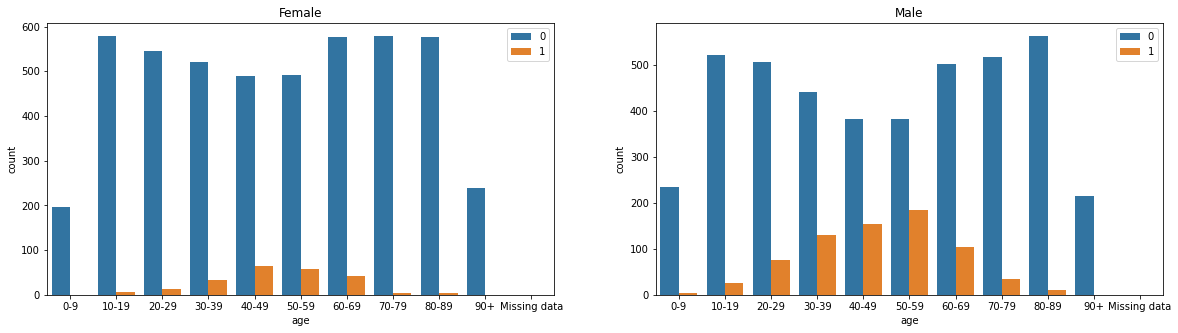

In [7]:
# confirm that our pattern is observable from frequencies
data = model_df.groupby(["sex", "age"])["smoker_flag"].value_counts().reset_index(name="count")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.barplot(x="age", 
            y="count", 
            hue="smoker_flag", 
            data=data.query("sex == 'Female'"),
            ax=ax[0]
).set_title("Female")
ax[0].legend(loc='upper right')

sns.barplot(x="age", 
            y="count", 
            hue="smoker_flag", 
            data=data.query("sex == 'Male'"),
            ax=ax[1]
).set_title("Male")

ax[1].legend(loc='upper right')

#### Create a basic ML model trained on our model dataset
We'll use the categorical Naive Bayes classifier for simplicity of predicting the smoker class.

In [8]:
# Convert smoker flag into categories
model_df["smoker"] = model_df["smoker_flag"].map({0:"non-smoker", 1:"smoker"})

In [9]:
# Select data for modeling
X=model_df[['sex', 'age']]
y=model_df['smoker'].values

# Encode categorical variables
enc = OrdinalEncoder()
X = enc.fit_transform(X)

clf = CategoricalNB()
clf.fit(X, y)

CategoricalNB()

#### Create a class that will enable us to use the model in Exhibit
The only requirement is that the model object has a method `apply_model`. Any parameters along with their values will be passed ot this function as keyword arguments.

In [10]:
class ExhibitModel:
    '''
    Encapsulate the information about your model in the ExhibitModel class
    '''
    
    def __init__(self, encoder, model, **kwargs):
        '''
        ExhibitModel is simply a convenient container for your model and associated objects.
        Use class attributes to save whatever it is your model requires to make predictions.
        '''
        
        self.model = model
        self.encoder = encoder
        
    def apply_model(self, input_df, **kwargs):
        '''
        Please follow the function signature to ensure your model is understood by Exhibit.
        Any hyperparameters that you specify in the specification will be passed to this
        function as keyword arguments. Make sure the function returns a data frame.
        '''
        
        sample = kwargs.get("sample", False)
        seed = kwargs.get("seed", 0)
        X = self.encoder.fit_transform(input_df[["sex", "age"]])
        
        if sample:
            probas = self.model.predict_proba(X)
            rng = np.random.default_rng(seed=seed)
            # when the model is certain of a class, we ensure that class is picked
            # rather than leaving it to a near certain chance.
            probas = [(1, 0) if x[0] > 0.995 else x for x in probas]       
            Y = [rng.choice(a=["non_smoker", "smoker"], p=probas[i]) for i in range(len(probas))]
        else:
            Y = self.model.predict(X)
        
        input_df["smoker"] = Y
        
        return input_df

In [11]:
model = ExhibitModel(encoder=enc, model=clf)

#### Pickle the model object using `dill`

In [12]:
with open("../exhibit/models/smoker_model.pickle", "wb") as f:
    dill.dump(model, f)

#### Apply the model to a new dataset

In [13]:
with open("../exhibit/models/smoker_model.pickle", "rb") as f:
    smoker_model = dill.load(f)    

In [14]:
df = pd.read_csv("../exhibit/sample/_data/inpatients.csv")

In [15]:
df.head()

,quarter_date,hb_code,hb_name,loc_code,loc_name,measure,stays,los,avlos,sex,age
0,2018-12-31,S08000015,NHS Ayrshire & Arran,A101H,Arran War Memorial Hospital,Elective Inpatients,0,0,NaN,Female,20-29
1,2018-03-31,S08000015,NHS Ayrshire & Arran,S08000015,NHS Ayrshire & Arran,Elective Inpatients,20,27,1.35,Female,0-9
2,2018-06-30,S08000015,NHS Ayrshire & Arran,S08000015,NHS Ayrshire & Arran,Elective Inpatients,28,35,1.25,Female,0-9
3,2018-09-30,S08000015,NHS Ayrshire & Arran,S08000015,NHS Ayrshire & Arran,Elective Inpatients,20,21,1.05,Female,0-9
4,2018-12-31,S08000015,NHS Ayrshire & Arran,S08000015,NHS Ayrshire & Arran,Elective Inpatients,20,22,1.10,Female,0-9


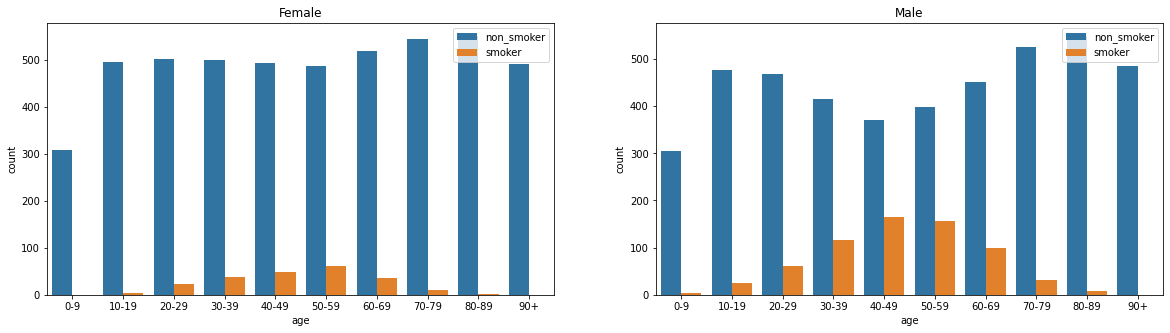

In [16]:
smoker_data = (
    smoker_model.apply_model(df, sample=True).groupby(["sex", "age"])["smoker"].value_counts().reset_index(name="count"))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.barplot(x="age", 
            y="count", 
            hue="smoker", 
            data=smoker_data.query("sex == 'Female'"),
            ax=ax[0]
).set_title("Female")
ax[0].legend(loc='upper right')

sns.barplot(x="age", 
            y="count", 
            hue="smoker", 
            data=smoker_data.query("sex == 'Male'"),
            ax=ax[1]
).set_title("Male")

ax[1].legend(loc='upper right')